# <font color='red'>SGD Algorithm and SVD decomposition to predict movie ratings</font>

# Problem statement
- we need to predict the rating given by the user_i to the movie_j for the given dataset

Predicted rating $\hat{y}_{ij}$ for user i, movied j pair is calcuated as $\hat{y}_{ij} = \mu + b_i + c_j + u_i^T v_j$ , here we will be finding the best values of $b_{i}$ and $c_{j}$ using SGD algorithm with the optimization problem for N users and M movies is defined as

$$
L = \min_{ b, c, \{ u_i \}_{i=1}^N, \{ v_j \}_{j=1}^M}
\quad
\alpha \Big(
    \sum_{j} \sum_{k} v_{jk}^2 
    + \sum_{i} \sum_{k} u_{ik}^2 
    + \sum_{i} b_i^2
    + \sum_{j} c_i^2
    \Big)
+ \sum_{i,j \in \mathcal{I}^{\text{train}}}
    (y_{ij} - \mu - b_i - c_j - u_i^T v_j)^2
$$

<ul>
<li><span class="math">\(\mu\)</span> : scalar mean rating</li>
<li><span class="math">\(b_i\)</span> : scalar bias term for user <span class="math">\(i\)</span></li>
<li><span class="math">\(c_j\)</span> : scalar bias term for movie <span class="math">\(j\)</span></li>
<li><span class="math">\(u_i\)</span> : K-dimensional vector for user <span class="math">\(i\)</span></li>
<li><span class="math">\(v_j\)</span> : K-dimensional vector for movie <span class="math">\(j\)</span></li>
</ul>

 $ \ $


In [121]:
#importing libraries
import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
from  sklearn.linear_model import LogisticRegression

<font color='red'> Reading the csv file </font>

In [122]:
data=pd.read_csv('ratings_train.csv')
data.head()

,user_id,item_id,rating
0,772,36,3
1,471,228,5
2,641,401,4
3,312,98,4
4,58,504,5


In [123]:
data.shape

(89992, 3)

<font color='red'>Create adjacency matrix </font>

In [124]:
row=data['user_id'].tolist()
column=data['item_id'].tolist()
ratings_data=data['rating'].tolist()

adjacency_matrix=csr_matrix((ratings_data, (row, column))).toarray()   #https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

In [125]:
adjacency_matrix.shape

(943, 1681)

**The unique items in the given csv file are 1662 only . But the id's vary from 0-1681 but they are not continuous and hence 
you'll get matrix of size 943x1681.**

<font color='red'> SVD decompostion</font>

<font color='red'>code for SVD decompostion</font>

In [127]:
#SVD decomposition with n_componenet as 5

from sklearn.utils.extmath import randomized_svd
import numpy as np 

U, Sigma, VT = randomized_svd(adjacency_matrix, n_components=50,n_iter=5, random_state=16)
print(U.shape)
print(Sigma.shape)
print(VT.T.shape)

(943, 50)
(50,)
(1681, 50)


<font color='red'>Compute mean of ratings</font>

In [128]:
def m_u(ratings):
    '''In this function, we will compute mean for all the ratings'''
    # you can use mean() function to do this
    # check this (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html) link for more details.
    
    return  data['rating'].mean()

In [129]:
mu=m_u(data['rating'])
print(mu)

3.529480398257623


<font color='red'>Initialize $B_{i}$ and $C_{j}$

In [131]:
def initialize(dim):
    '''In this function, we will initialize bias value 'B' and 'C'.'''
    # initalize the value to zeros 
    # return output as a list of zeros 
    v=np.zeros(dim)

    return v

In [132]:
dim= adjacency_matrix.shape[0]      # give the number of dimensions for b_i (Here b_i corresponds to users)
b_i=initialize(dim)

In [133]:
dim=adjacency_matrix.shape[1]     # give the number of dimensions for c_j (Here c_j corresponds to movies)
c_j=initialize(dim)

<font color='red'>Compute dL/db_i</font>

In [135]:
def derivative_db(user_id,item_id,rating,U,V,mu,alpha):
    '''In this function, we will compute dL/db_i'''
    
    l_b=2*alpha*(b_i[user_id])-2*(rating-mu-b_i[user_id]-c_j[item_id]-np.dot(U[user_id],V.T[item_id]))
    
    return l_b


<font color='red'>Compute dL/dc_j</font>

In [137]:
def derivative_dc(user_id,item_id,rating,U,V,mu, alpha):
    '''In this function, we will compute dL/dc_j'''
    
    l_c=2*alpha*(c_j[item_id])-2*(rating-mu-b_i[user_id]-c_j[item_id]-np.dot(U[user_id],V.T[item_id]))
    
    return l_c


<font color='red'>Compute MSE (mean squared error) for predicted ratings</font>


In [139]:
alpha=0.01 
epoch=10      #number of epoch
eta0=0.01     #learing rate
db=0          
dc=0
b_i=initialize(adjacency_matrix.shape[0])       # initialising b_i and c_j
c_j=initialize(adjacency_matrix.shape[1])
MSE=[]         #to store MSE for each epoch
EPOCh=[]       #to store the number of epoch
for k in range(epoch):                            #for each epoch
    for i in range(U.shape[0]):                   #for each user id
        for j in range(VT.shape[1]):              #for each movie id
            db=derivative_db(i,j,adjacency_matrix[i][j],U,VT,mu,alpha)  #computing gradient w.r.to user bias
            dc=derivative_dc(i,j,adjacency_matrix[i][j],U,VT,mu,alpha)  #computing gradient w.r.to movie bias
            b_i[i]-=eta0*db                                #update bias
            c_j[j]-=eta0*dc
            
    pre=[]      #to store predicted value
    act=[]      #to store actual value
    for i in range(U.shape[0]):                   #for each user id
        for j in range(VT.shape[1]):              #for each movie id
            
            predicted=mu+b_i[i]+c_j[j]+np.dot(U[i],VT.T[j])   #predicted value of rating
            pre.append(predicted)
            actual=adjacency_matrix[i][j]                     #actual value of rating
            act.append(actual)
    
    mse=mean_squared_error(act,pre)                        #finding mean square error
    MSE.append(mse)
    EPOCh.append(k+1)
    print(f"MSE for Epoch {k+1} ",mse)
    print("*"*50)

MSE for Epoch 1  4.847428705992636
**************************************************
MSE for Epoch 2  1.3832934234373997
**************************************************
MSE for Epoch 3  1.1906714999112504
**************************************************
MSE for Epoch 4  0.9188556703360091
**************************************************
MSE for Epoch 5  0.7247999293142194
**************************************************
MSE for Epoch 6  0.6807862130327451
**************************************************
MSE for Epoch 7  0.6735121787944652
**************************************************
MSE for Epoch 8  0.6584205547939809
**************************************************
MSE for Epoch 9  0.6520789412444189
**************************************************
MSE for Epoch 10  0.6518578911078403
**************************************************


<font color='red'>Plot epoch number vs MSE </font>


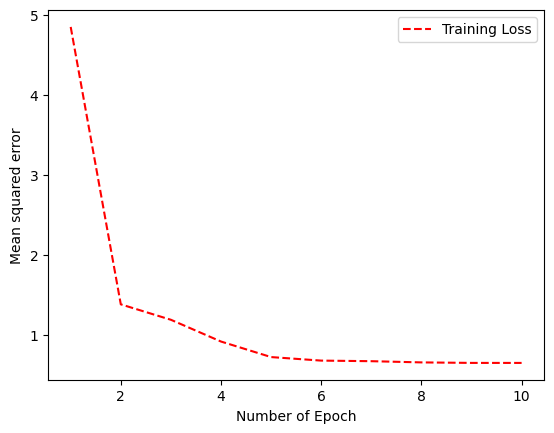

In [140]:
from matplotlib import pyplot as plt
plt.plot(EPOCh, MSE, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Number of Epoch')
plt.ylabel('Mean squared error')
plt.show()

<br>

# <font color='red'> Task 2</font>

- For this task we have to consider the user_matrix U and the user_info.csv file.
- we have to consider is_male columns as  output features and rest as input features. Now we have to fit a model by posing this problem as binary classification task.
- we can apply any model like Logistic regression or Decision tree and check the performance of the model. 
- Do plot confusion matrix after fitting our model and write our observations how our model is performing in this task.

- Optional work- we can try scaling your U matrix.Scaling means changing the values of n_componenets while performing svd
  and then check our results.

In [141]:
#reading data
data_2=pd.read_csv('user_info.csv.txt')
data_2.head()

,user_id,age,is_male,orig_user_id
0,0,24,1,1
1,1,53,0,2
2,2,23,1,3
3,3,24,1,4
4,4,33,0,5


In [142]:
#extracting y_true label
Y_actual=data_2['is_male'].tolist()


### Creating age feature and merge with user vector

In [143]:
#minmax scaling age feature

scaler = MinMaxScaler()
data_2['age'] = scaler.fit_transform(data_2['age'].values.reshape(-1,1))
age=data_2['age'].tolist() 
age=np.array(age).reshape(-1,1)       #reshaping array

In [144]:
age.shape     #shape of age feature

(943, 1)

In [145]:
U.shape         #shape of user vector

(943, 50)

In [146]:
# Adding "age" feature to User vector (array) using append() method
U_with_age = np.append(U, age, axis=1)

In [147]:
U_with_age.shape        #dim of user vector with age feature in it.

(943, 51)

## Logistic regression

#### Hyperparameter tuning

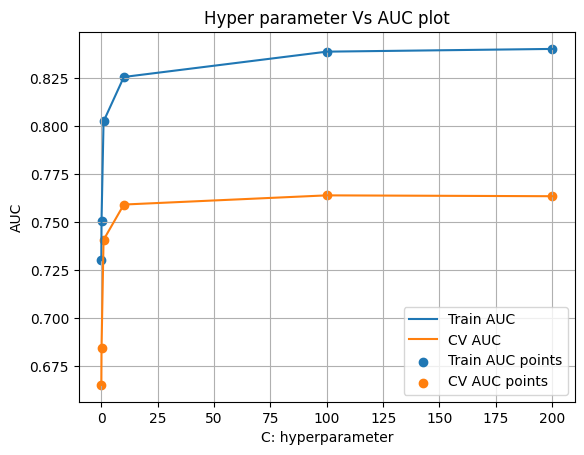

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.034177,0.002984,0.005213,0.007372,200,l2,"{'C': 200, 'penalty': 'l2'}",0.749068,0.757946,0.783768,0.763594,0.014718,2,0.852116,0.839946,0.828712,0.840258,0.009558
1,0.039574,0.003901,0.001335,0.000472,100,l2,"{'C': 100, 'penalty': 'l2'}",0.746762,0.758784,0.786577,0.764041,0.016674,1,0.850712,0.838238,0.827556,0.838835,0.009463
2,0.019951,0.001464,0.001334,0.000473,10,l2,"{'C': 10, 'penalty': 'l2'}",0.735479,0.755827,0.786478,0.759261,0.020962,3,0.837493,0.825221,0.814256,0.825657,0.009491
3,0.010005,0.001639,0.001001,0.000002,1.0,l2,"{'C': 1.0, 'penalty': 'l2'}",0.724784,0.751540,0.746316,0.740880,0.011580,4,0.826763,0.813580,0.767252,0.802532,0.025521
4,0.005904,0.000146,0.000994,0.000814,0.1,l2,"{'C': 0.1, 'penalty': 'l2'}",0.691327,0.732321,0.629774,0.684474,0.042144,5,0.787747,0.802505,0.662069,0.750774,0.063012


In [148]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

lr=LogisticRegression()
parameters={"C":[200,100, 10, 1.0, 0.1, 0.01],"penalty":['l2']} #hyperparameter list

clf = GridSearchCV(lr, parameters, cv=3, scoring='roc_auc',return_train_score=True) #applying gridsearch to find best hyperparameter
clf.fit(U_with_age, Y_actual)    #fitting the LR model with train data

results = pd.DataFrame.from_dict(clf.cv_results_)   #storing Gridsearch results

train_auc= results['mean_train_score']       #storing required Gridsearch results in required variable
cv_auc = results['mean_test_score'] 
C =  results['param_C'].tolist()
plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.scatter(C, train_auc, label='Train AUC points')
plt.scatter(C, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

####  Fitting with best C=100

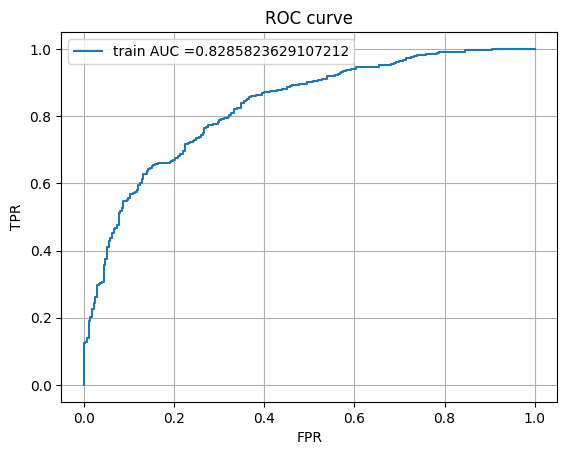

In [149]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

lr=LogisticRegression(C=100,penalty='l2')

lr.fit(U_with_age, Y_actual)              #fitting the LR model with best alpha 
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class,not the predicted outputs

y_train_pred_proba = lr.predict_proba(U_with_age)    
y_test_pred_proba = lr.predict_proba(U_with_age)

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_actual, y_train_pred_proba[:,[1]])        #find FPR and TPR for plotting roc curve
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))   #finding area under the ROC curve using FPR and TPR
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.grid()
plt.show()

#### Plotting confustion matrix

C:\Users\natar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


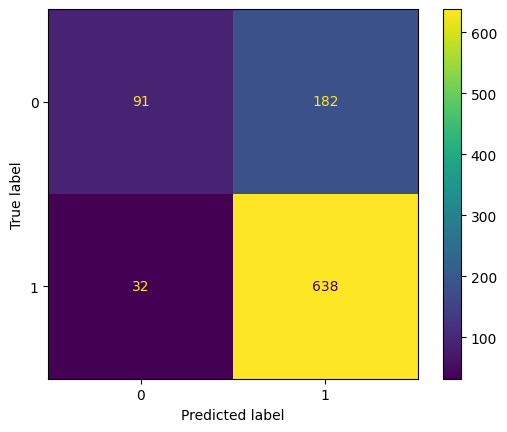

In [150]:
plot_confusion_matrix(lr, U_with_age, Y_actual)

# Observation
- We can see that we get Very high AUC score of 0.8285 while trying to predict the gender of the user with the given SVD decomposed user vector and age feature.


- So we can say that the user vector that we got by decompoding adjacency_matrix in SVD, have captured some information about the user's gender also.

# <font color='red'>Optional work</font>

### Finding best hyperparameter for each User vector of different sizes

User vector dimension before adding age feature is  10


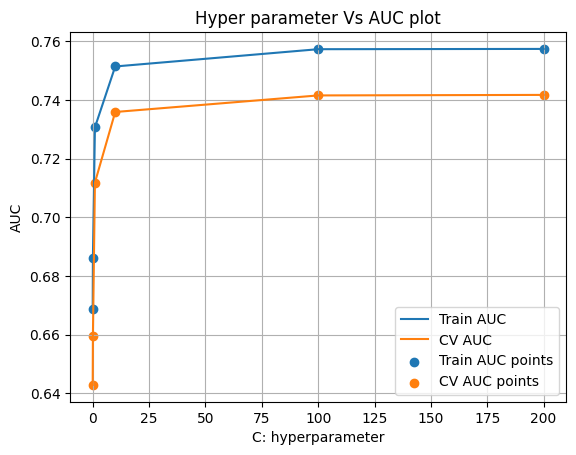

User vector dimension before adding age feature is  20


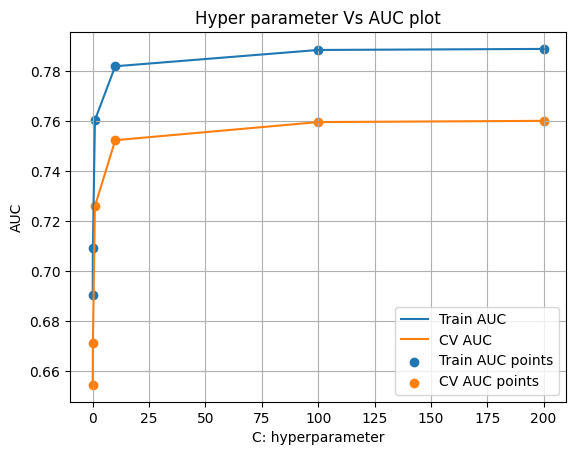

User vector dimension before adding age feature is  30


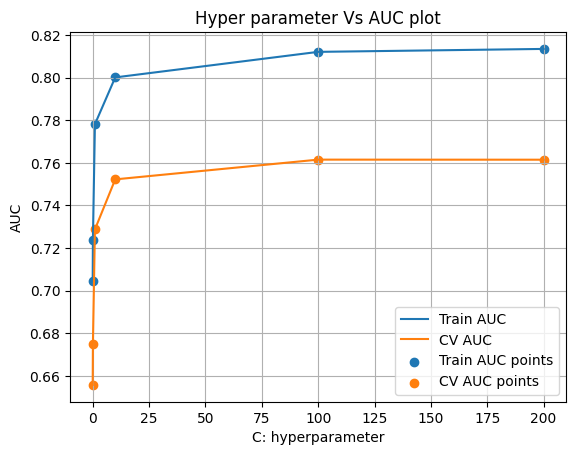

User vector dimension before adding age feature is  40


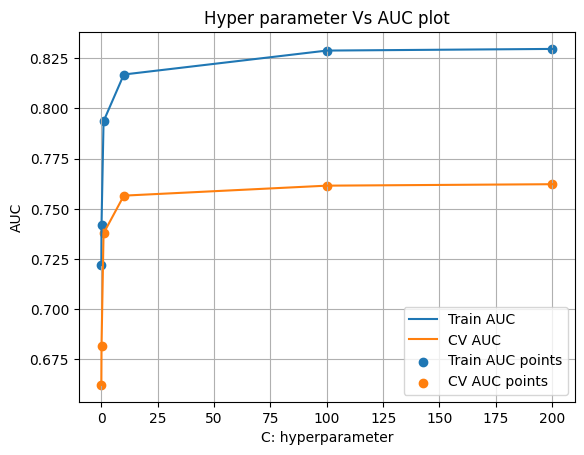

User vector dimension before adding age feature is  50


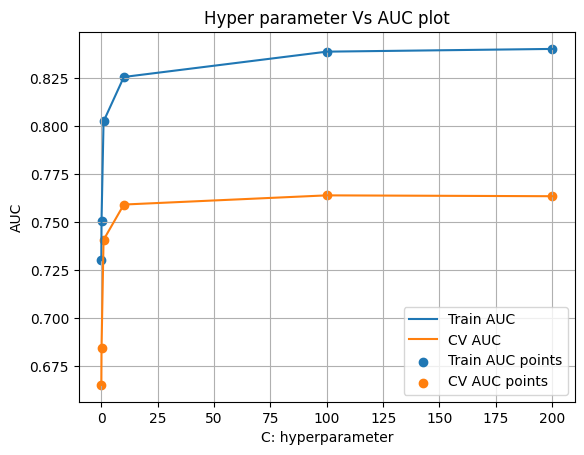

User vector dimension before adding age feature is  60


C:\Users\natar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\natar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

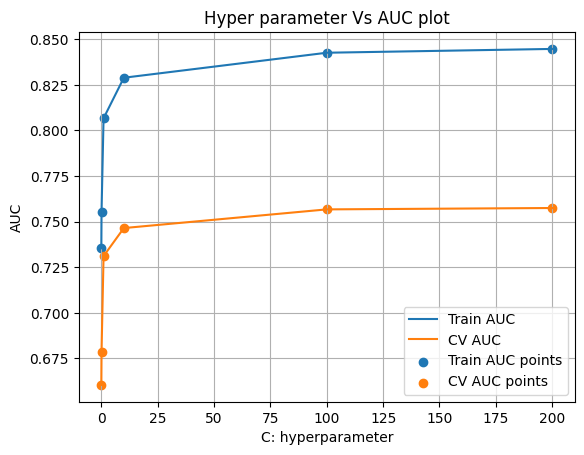

User vector dimension before adding age feature is  70


C:\Users\natar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\natar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

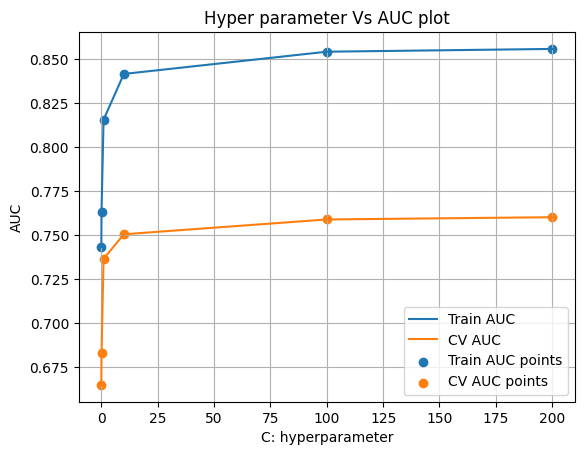

User vector dimension before adding age feature is  80


C:\Users\natar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


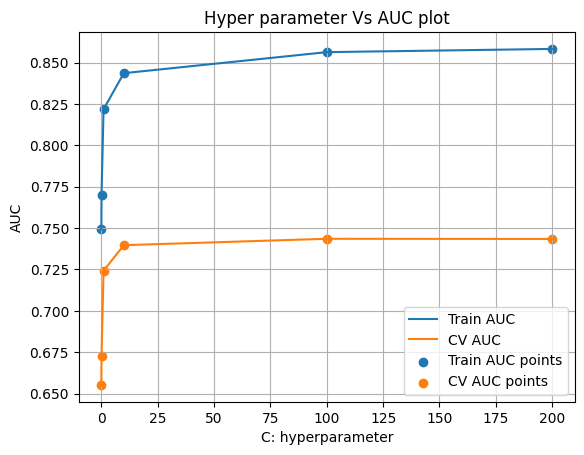

In [151]:
for i in range(10,81,10):     #for diffent n_components size,create U and VT

    U, Sigma, VT = randomized_svd(adjacency_matrix, n_components=i,n_iter=5, random_state=16)
    print("User vector dimension before adding age feature is ",U.shape[1])

    
    U_with_age = np.append(U, age, axis=1)  #adding age feature to user vector
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    
    #hyper paramater tuning 
    lr=LogisticRegression()
    parameters={"C":[200,100, 10, 1.0, 0.1, 0.01],"penalty":['l2']} #hyperparameter list

    clf = GridSearchCV(lr, parameters, cv=3, scoring='roc_auc',return_train_score=True) #applying gridsearch to find best hyperparameter
    clf.fit(U_with_age, Y_actual)    #fitting the LR model with train data

    results = pd.DataFrame.from_dict(clf.cv_results_)   #storing Gridsearch results
    train_auc= results['mean_train_score']       #storing required Gridsearch results in required variable
    cv_auc = results['mean_test_score'] 
    C =  results['param_C'].tolist()
    plt.plot(C, train_auc, label='Train AUC')
    plt.plot(C, cv_auc, label='CV AUC')
    plt.scatter(C, train_auc, label='Train AUC points')
    plt.scatter(C, cv_auc, label='CV AUC points')
    plt.legend()
    plt.xlabel("C: hyperparameter")
    plt.ylabel("AUC")
    plt.title("Hyper parameter Vs AUC plot")
    plt.grid()
    plt.show()



## We can see that for the C=100 we get max cv AUC score for all the tested size of the feature vectors

### Fitting best hyperparameter c=100 for each User vector of different sizes  and Calculate AUC score for different dimentional user vectors 

User vector dimension before adding age feature is 10 and respective AUC score is 0.7539445628997867 


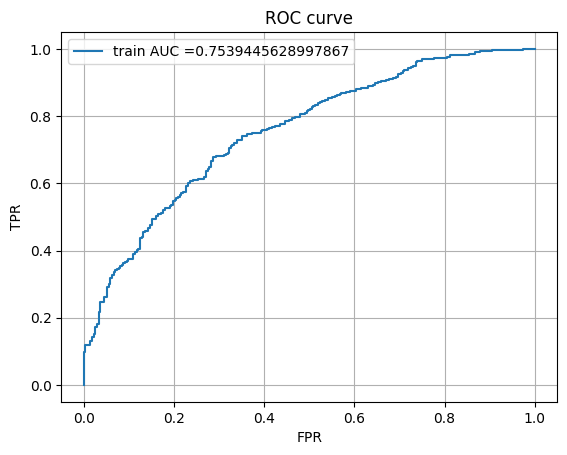

User vector dimension before adding age feature is 20 and respective AUC score is 0.7847411295172491 


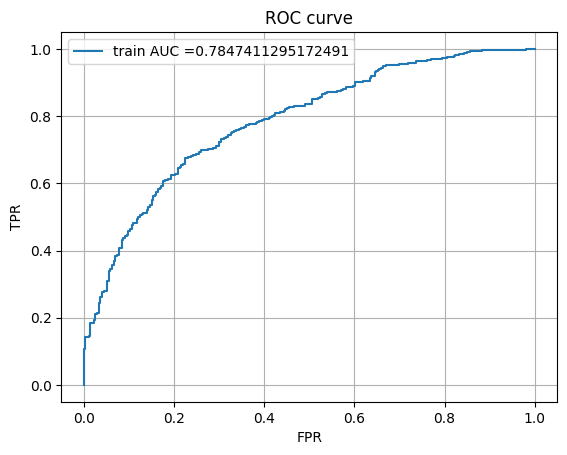

User vector dimension before adding age feature is 30 and respective AUC score is 0.8060794926466568 


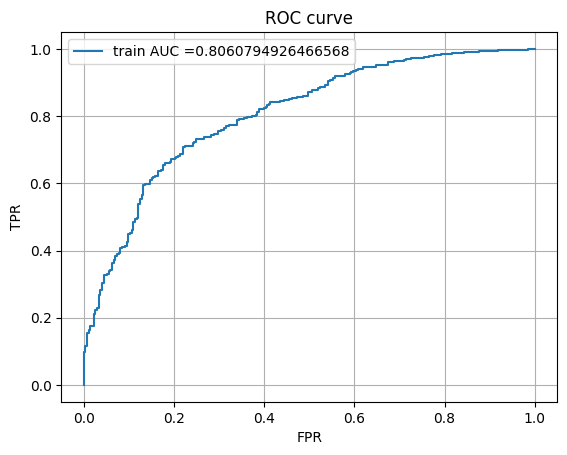

User vector dimension before adding age feature is 40 and respective AUC score is 0.8195615329943687 


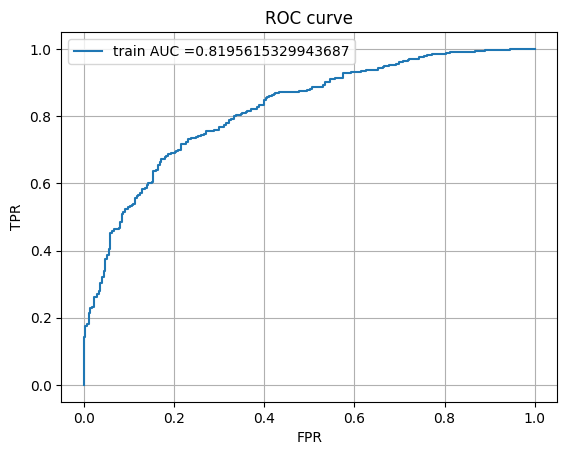

User vector dimension before adding age feature is 50 and respective AUC score is 0.8285823629107212 


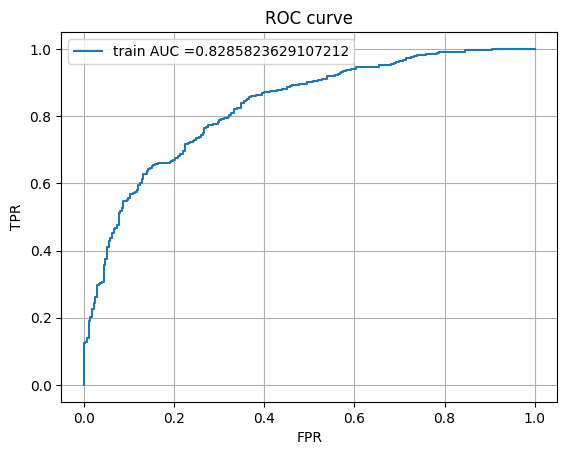

User vector dimension before adding age feature is 60 and respective AUC score is 0.8295609862774042 


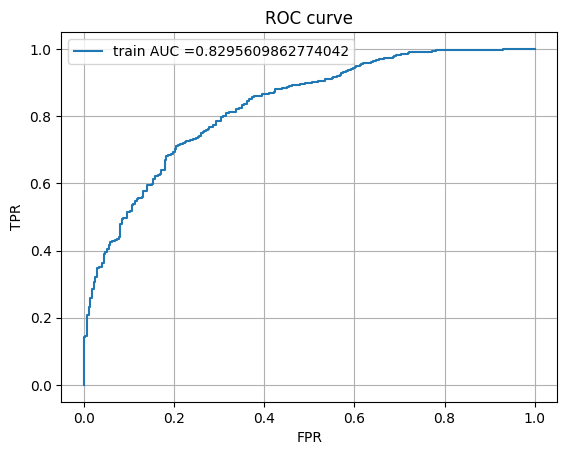

User vector dimension before adding age feature is 70 and respective AUC score is 0.8378656169700945 


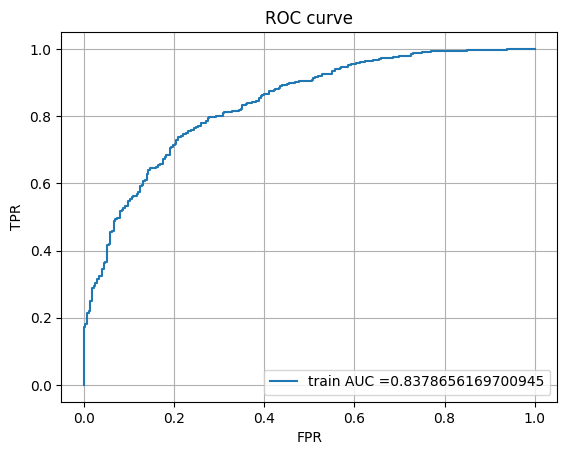

User vector dimension before adding age feature is 80 and respective AUC score is 0.8383467278989667 


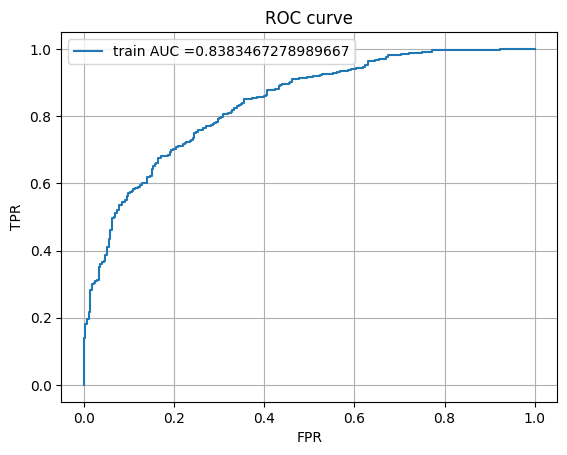

In [152]:
AUC=[]
dim=[]
for i in range(10,81,10):               #for diffent n_components size,create U and VT
    U, Sigma, VT = randomized_svd(adjacency_matrix, n_components=i,n_iter=5, random_state=16)  
    U_with_age = np.append(U, age, axis=1)   #adding feature vector with user vector

    lr=LogisticRegression(C=100,penalty='l2') 
    lr.fit(U_with_age, Y_actual)              #fitting the LR model with best alpha 
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class,not the predicted outputs

    y_train_pred_proba = lr.predict_proba(U_with_age)    
    y_test_pred_proba = lr.predict_proba(U_with_age)
    train_fpr, train_tpr, tr_thresholds = roc_curve(Y_actual, y_train_pred_proba[:,[1]])        #find FPR and TPR for plotting roc curve
    print(f"User vector dimension before adding age feature is {U.shape[1]} and respective AUC score is {auc(train_fpr, train_tpr)} ")
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))   #finding area under the ROC curve using FPR and TPR
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC curve")
    plt.grid()
    plt.show()
    
    AUC.append(auc(train_fpr, train_tpr))
    dim.append(i)


#### Dimentional of user vector and their respective AUC score

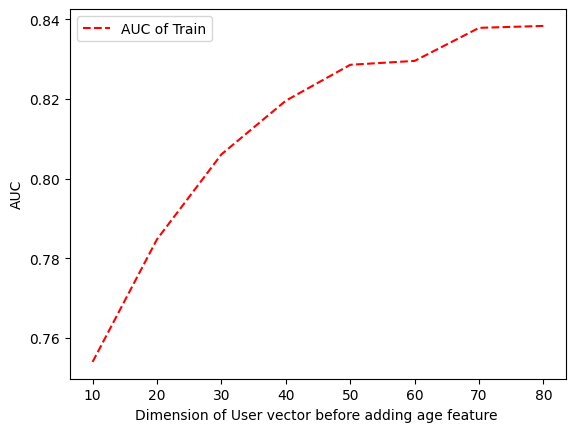

In [153]:
from matplotlib import pyplot as plt
plt.plot(dim, AUC, 'r--')
plt.legend(['AUC of Train'])
plt.xlabel('Dimension of User vector before adding age feature ')
plt.ylabel('AUC')
plt.show()

## Observation
- as number of dimention of user vector increases, the AUC score also increases which means as dim increases, the user vector can hold more information about that user which results in better performance.
